In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
df_encoded = pd.read_csv("real_estate_texas_500_2024.csv")  # Change to your actual dataset file

# Drop unnecessary columns (e.g., 'id' and text-based features)
df_encoded.drop(columns=["id", "text", "url"], errors="ignore", inplace=True)

# Identify categorical columns automatically
categorical_columns = df_encoded.select_dtypes(include=["object"]).columns.tolist()

# Convert categorical columns to numerical (One-Hot Encoding)
df_encoded = pd.get_dummies(df_encoded, columns=categorical_columns, drop_first=True)

# Now that all columns are numerical, we can safely fill missing values
df_encoded.fillna(df_encoded.median(numeric_only=True), inplace=True)

# Ensure numerical data types are correct
df_encoded = df_encoded.astype({col: "float64" for col in df_encoded.columns if col != "listPrice"})

# Check the data
print(df_encoded.info())
print(df_encoded.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listPrice           501 non-null    float64
 1   baths               501 non-null    float64
 2   baths_full          501 non-null    float64
 3   baths_full_calc     501 non-null    float64
 4   beds                501 non-null    float64
 5   sqft                501 non-null    float64
 6   stories             501 non-null    float64
 7   year_built          501 non-null    float64
 8   sub_type_townhouse  501 non-null    float64
 9   type_farm           501 non-null    float64
 10  type_land           501 non-null    float64
 11  type_mobile         501 non-null    float64
 12  type_multi_family   501 non-null    float64
 13  type_single_family  501 non-null    float64
 14  type_townhomes      501 non-null    float64
dtypes: float64(15)
memory usage: 58.8 KB
None
   listPrice  b

In [3]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X_rf = df_encoded.drop(columns=["listPrice"])  # Features
y_rf = df_encoded["listPrice"]  # Target variable

# Train-test split (80% training, 20% testing)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

# Check shapes
print(f"Training set: {X_train_rf.shape}, Testing set: {X_test_rf.shape}")

Training set: (400, 14), Testing set: (101, 14)


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_rf, y_train_rf)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}


In [5]:
# need to retrain the model with the optimized parameters, so we create a new Random Forest model using the best parameters
rf_model_best = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42
)

# Train the model on the full training set
rf_model_best.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=50,
                      random_state=42)

In [6]:
# now we can make the predictions on the test set
y_pred_best = rf_model_best.predict(X_test_rf)

In [7]:
# now evaluate the model's performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute evaluation metrics
mae_best = mean_absolute_error(y_test_rf, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test_rf, y_pred_best))
r2_best = r2_score(y_test_rf, y_pred_best)

# Print results
print(f"Optimized RF - MAE: {mae_best:.2f}")
print(f"Optimized RF - RMSE: {rmse_best:.2f}")
print(f"Optimized RF - R² Score: {r2_best:.2f}")

Optimized RF - MAE: 135308.45
Optimized RF - RMSE: 290567.78
Optimized RF - R² Score: 0.12


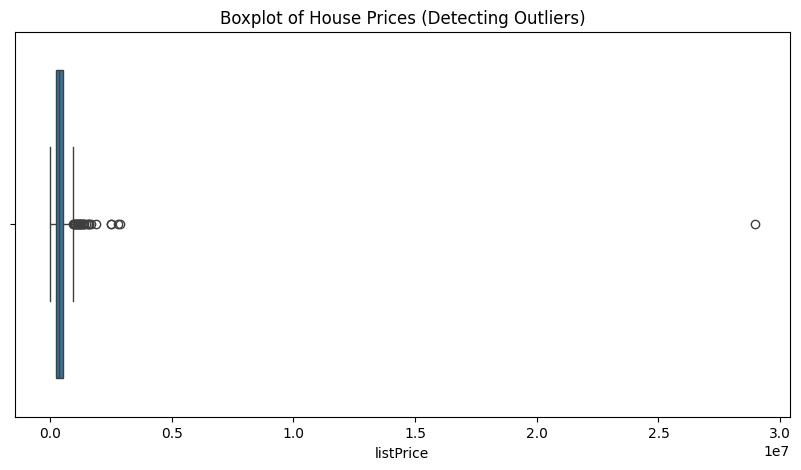

In [8]:
# visualizing the outliers
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(x=df_encoded["listPrice"])
plt.title("Boxplot of House Prices (Detecting Outliers)")
plt.show()

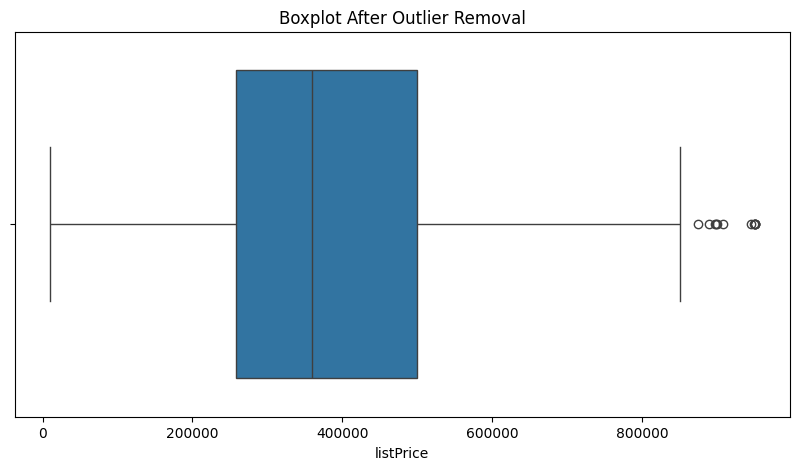

In [10]:
# need to remove outliers according to the results of the boxplot
Q1 = df_encoded["listPrice"].quantile(0.25)  # 25th percentile
Q3 = df_encoded["listPrice"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_encoded = df_encoded[(df_encoded["listPrice"] >= lower_bound) & (df_encoded["listPrice"] <= upper_bound)]

# Plot again to confirm
plt.figure(figsize=(10,5))
sns.boxplot(x=df_encoded["listPrice"])
plt.title("Boxplot After Outlier Removal")
plt.show()

In [11]:
# Use a stricter outlier removal threshold
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR